<div style="background-color:yellow; text-align:center; text-align:center; padding:40px;">
<h1  style="color:red;" > DI-725 : Transformers and Attention-Based Deep Networks </h1>   
<h2  style="color:red;" > Assignment - 1 </h2>
<br>
<br>
<h4  style="color:red;" >Turgay Yıldız</h4>
<br>
<h4  style="color:red;" >Graduate School of Informatics,  Middle East Technical University (METU)</h4>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  First Import the Relevant Packages  </h2>
</div>

In [1]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import GPT2Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from torch.utils.data import Dataset, DataLoader, random_split

from torch.optim import AdamW

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

#nltk.download("punkt")
#nltk.download("averaged_perceptron_tagger")
#nltk.download('averaged_perceptron_tagger_eng')
#nltk.download("wordnet")
#nltk.download("stopwords")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tqdm

import wandb
import os

from torch.amp import GradScaler, autocast

/home/turgay/anaconda3/envs/DI_725_assignment_1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


In [3]:
print(os.getcwd())

/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_1


In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DI_725_Assignment_1__2697258.ipynb"

In [5]:
run  =  wandb.init(project="DI_725_Assignment_1___2697258", entity="DI_725_Assignment_1") 

wandb: Currently logged in as: turgay-yildiz-phi-e-pi (DI_725_Assignment_1). Use `wandb login --relogin` to force relogin


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  First Import Dataset  </h2>
</div>

In [2]:
path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_1/assignment_1/data/customer_service/"

In [3]:
df_train = pd.read_csv(path + "train.csv") 
df_test  = pd.read_csv(path + "test.csv")

In [4]:
df_train.head()

,issue_area,issue_category,issue_sub_category,issue_category_sub_category,customer_sentiment,product_category,product_sub_category,issue_complexity,agent_experience_level,agent_experience_level_desc,conversation
0,Login and Account,Mobile Number and Email Verification,Verification requirement for mobile number or ...,Mobile Number and Email Verification -> Verifi...,neutral,Appliances,Oven Toaster Grills (OTG),medium,junior,"handles customer inquiries independently, poss...",Agent: Thank you for calling BrownBox Customer...
1,Cancellations and returns,Pickup and Shipping,Reasons for being asked to ship the item,Pickup and Shipping -> Reasons for being asked...,neutral,Electronics,Computer Monitor,less,junior,"handles customer inquiries independently, poss...",Agent: Thank you for calling BrownBox customer...
2,Cancellations and returns,Replacement and Return Process,Inability to click the 'Cancel' button,Replacement and Return Process -> Inability to...,neutral,Appliances,Juicer/Mixer/Grinder,medium,experienced,"confidently handles complex customer issues, e...",Agent: Thank you for calling BrownBox Customer...
3,Login and Account,Login Issues and Error Messages,Error message regarding exceeded attempts to e...,Login Issues and Error Messages -> Error messa...,neutral,Appliances,Water Purifier,less,inexperienced,"may struggle with ambiguous queries, rely on c...","Customer: Hi, I am facing an issue while loggi..."
4,Order,Order Delivery Issues,Delivery not attempted again,Order Delivery Issues -> Delivery not attempte...,negative,Electronics,Bp Monitor,medium,experienced,"confidently handles complex customer issues, e...",Agent: Thank you for contacting BrownBox custo...


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Exploratory Data Analysis (EDA)  </h2>
</div>


## 1-) Check for Missing Values : 

In [5]:
if 1:
    
    print(df_train.isnull().sum())
    print(df_test.isnull().sum())

issue_area                     0
issue_category                 0
issue_sub_category             0
issue_category_sub_category    0
customer_sentiment             0
product_category               0
product_sub_category           0
issue_complexity               0
agent_experience_level         0
agent_experience_level_desc    0
conversation                   0
dtype: int64
issue_area                     0
issue_category                 0
issue_sub_category             0
issue_category_sub_category    0
customer_sentiment             0
product_category               0
product_sub_category           0
issue_complexity               0
agent_experience_level         0
agent_experience_level_desc    0
conversation                   0
dtype: int64


## 2-) Check the Sentiment Class Distribution : 

/tmp/ipykernel_19987/1334598048.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train['customer_sentiment'], palette='viridis')


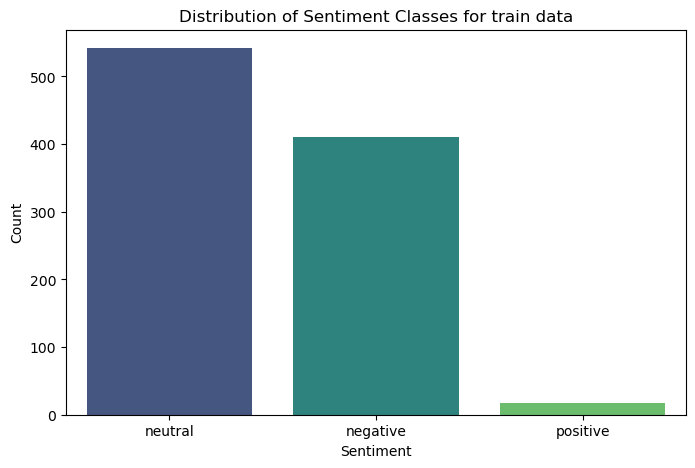

In [6]:
if 1:
    
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df_train['customer_sentiment'], palette='viridis')
    plt.title("Distribution of Sentiment Classes for train data")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

/tmp/ipykernel_19987/525015770.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_test['customer_sentiment'], palette='viridis')


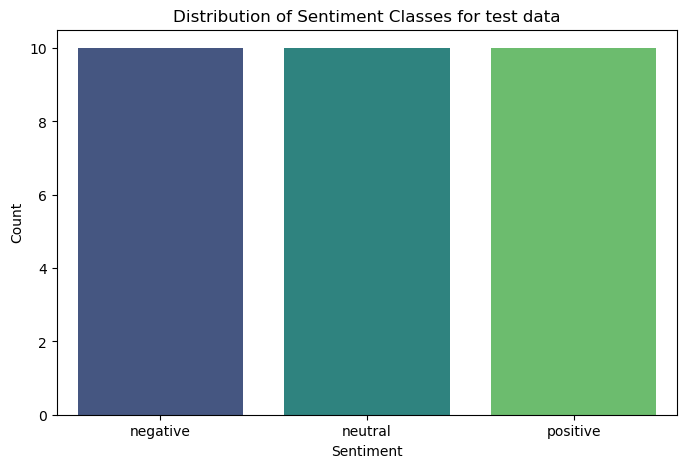

In [7]:
if 1:
    
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df_test['customer_sentiment'], palette='viridis')
    plt.title("Distribution of Sentiment Classes for test data")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

In [8]:
df_train['customer_sentiment'].value_counts().sort_index()

customer_sentiment
negative    411
neutral     542
positive     17
Name: count, dtype: int64

## 3-) Statistical Summary : 

In [9]:
df_train.describe()

,issue_area,issue_category,issue_sub_category,issue_category_sub_category,customer_sentiment,product_category,product_sub_category,issue_complexity,agent_experience_level,agent_experience_level_desc,conversation
count,970,970,970,970,970,970,970,970,970,970,970
unique,6,40,109,109,3,3,50,3,3,3,968
top,Cancellations and returns,Return and Exchange,Verification requirement for mobile number or ...,Mobile Number and Email Verification -> Verifi...,neutral,Appliances,Water Purifier,less,junior,"handles customer inquiries independently, poss...","Agent: You're welcome, Jane. Have a great day!"
freq,277,92,17,17,542,454,26,472,490,490,3


## Baseline : 

In [10]:
   542 / 970

0.5587628865979382

## 4-)  Correlation Analysis  : 

In [11]:
df_train.dtypes

issue_area                     object
issue_category                 object
issue_sub_category             object
issue_category_sub_category    object
customer_sentiment             object
product_category               object
product_sub_category           object
issue_complexity               object
agent_experience_level         object
agent_experience_level_desc    object
conversation                   object
dtype: object

In [12]:
if 1:
    for i in df_train:
        df_train[i] = df_train[i].astype("category").cat.codes

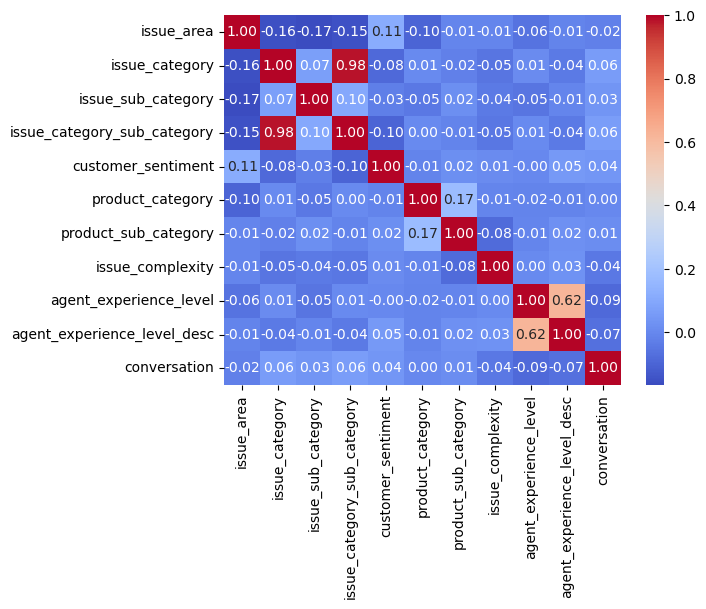

In [13]:
if 1:
    sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()

In [14]:
df_train.columns

Index(['issue_area', 'issue_category', 'issue_sub_category',
       'issue_category_sub_category', 'customer_sentiment', 'product_category',
       'product_sub_category', 'issue_complexity', 'agent_experience_level',
       'agent_experience_level_desc', 'conversation'],
      dtype='object')

In [15]:
len(df_train.columns) 

11

In [18]:
sns.pairplot(df_train)
plt.savefig('pairplot_image.png', dpi=300) 
plt.close() 

/home/turgay/anaconda3/envs/DI_725_assignment_1/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


/home/turgay/anaconda3/envs/DI_725_assignment_1/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


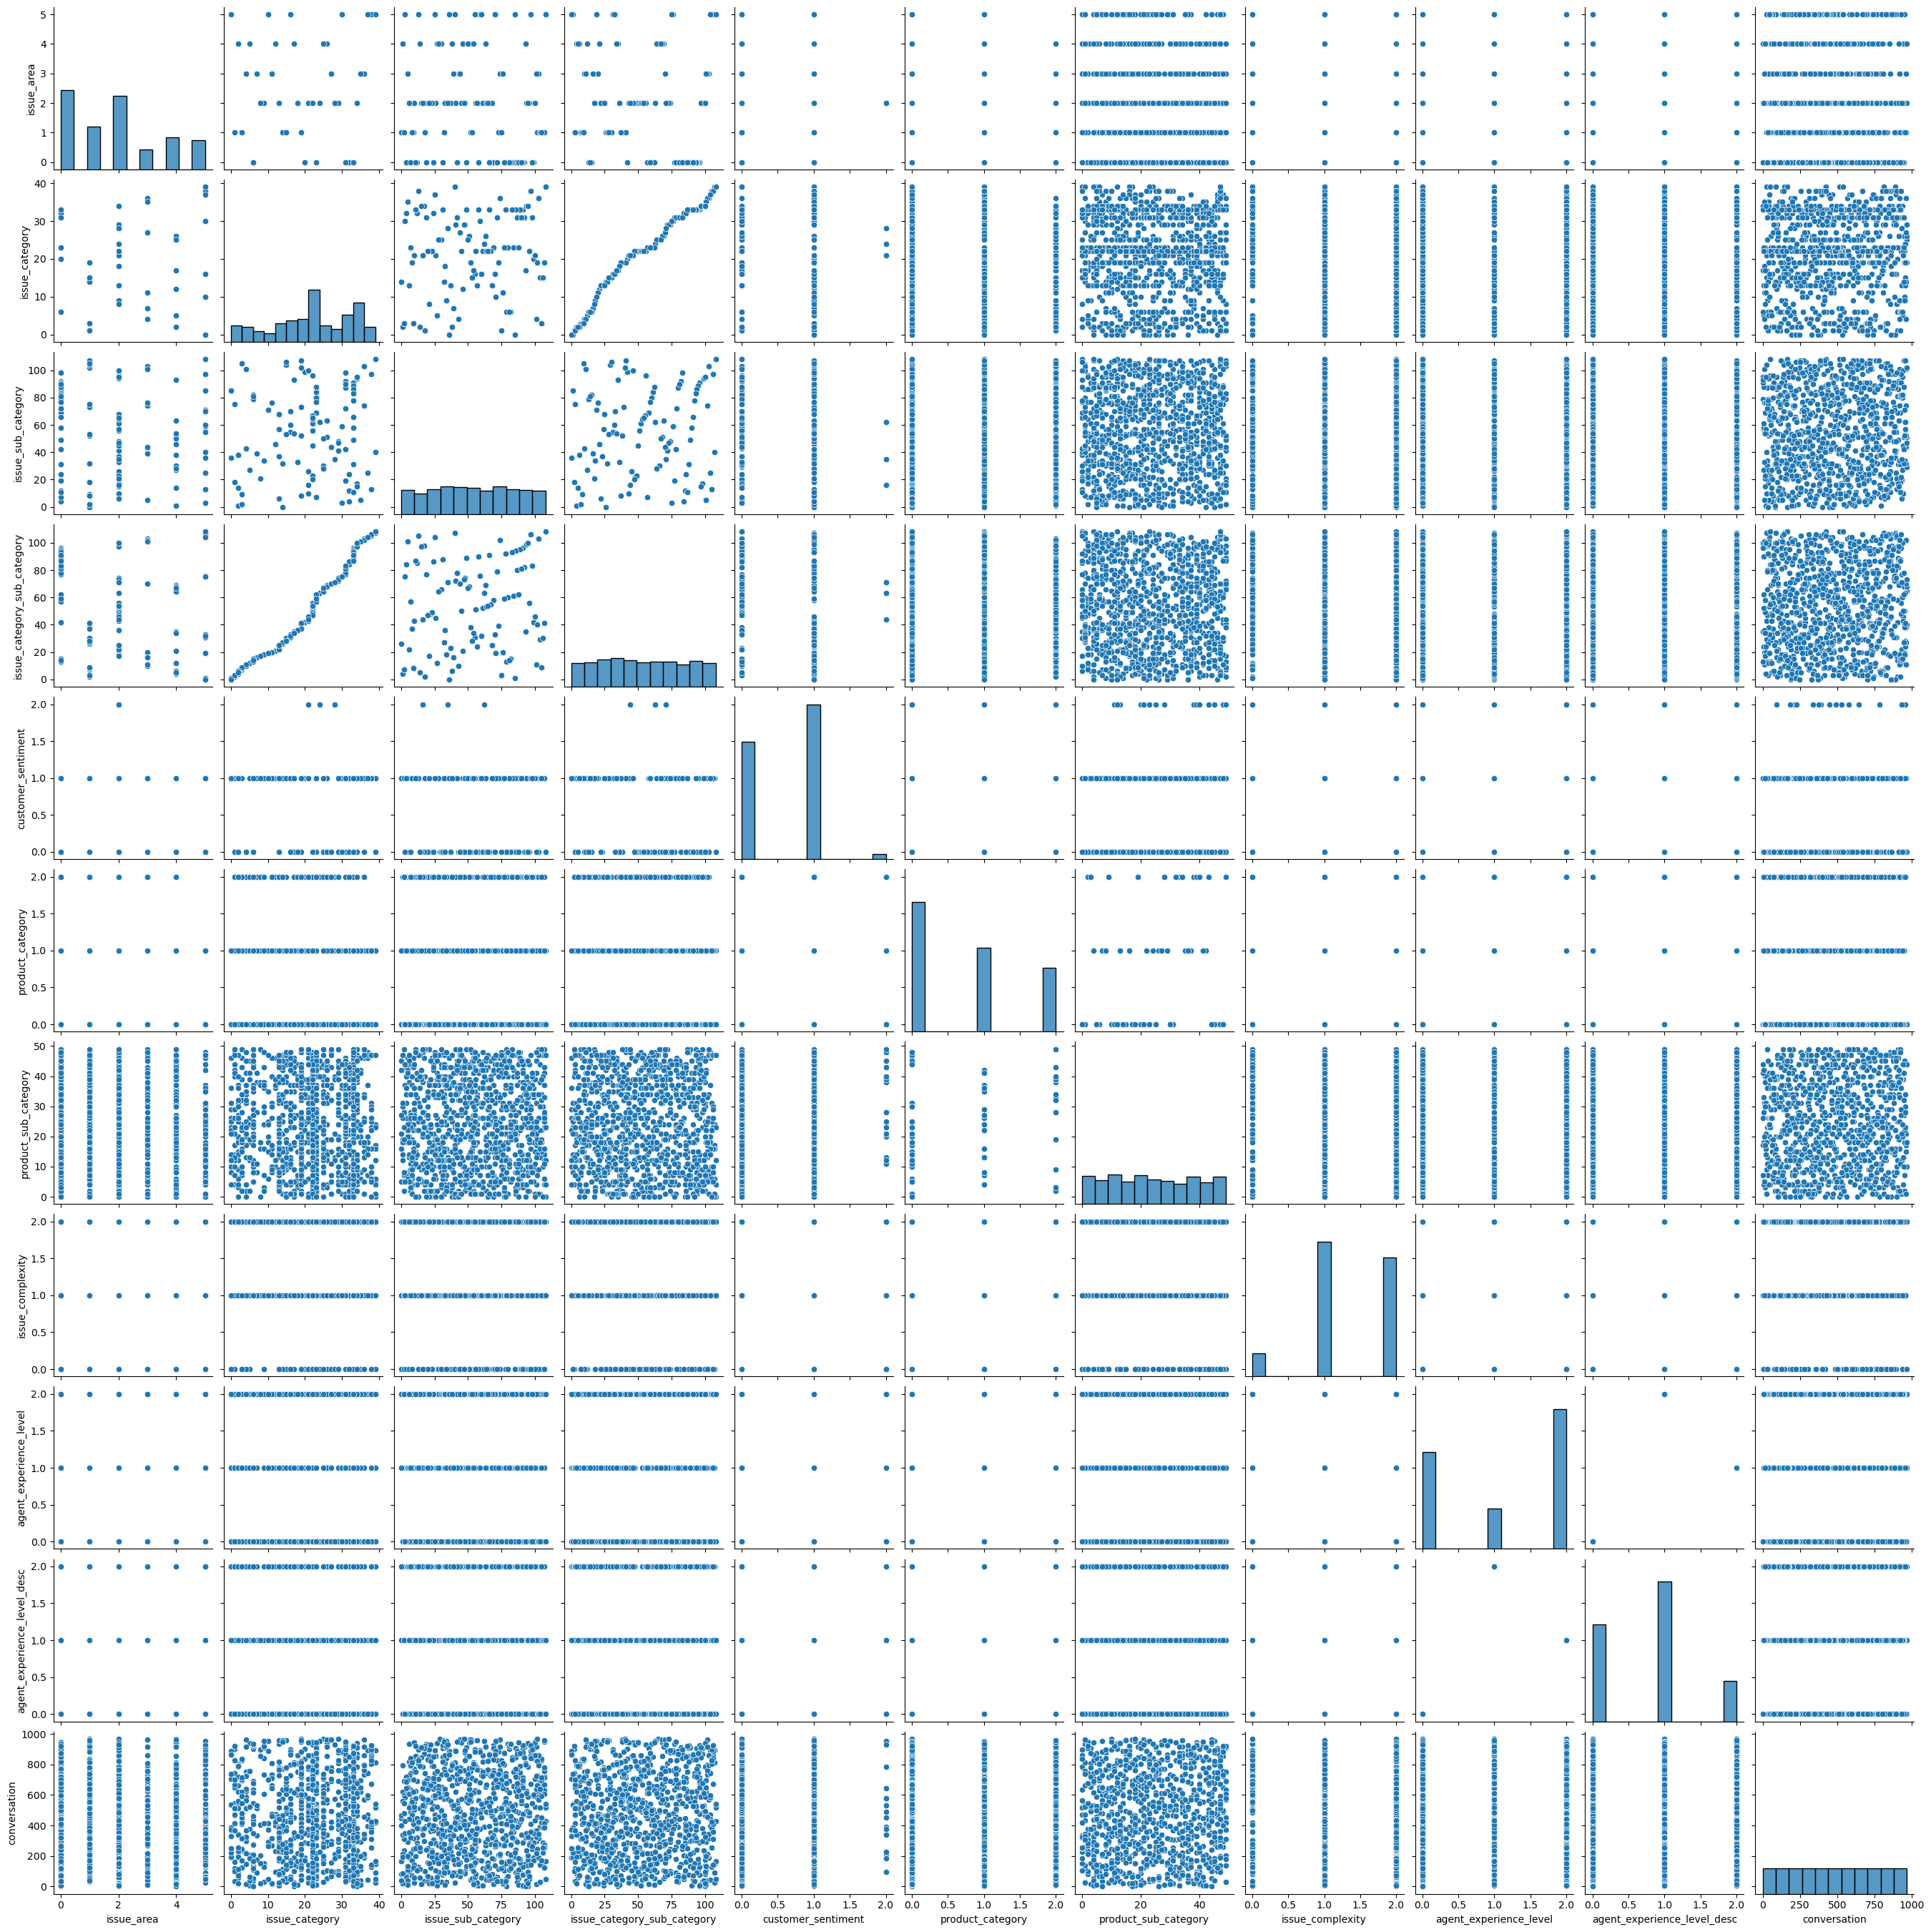

In [19]:
sns.pairplot(df_train)

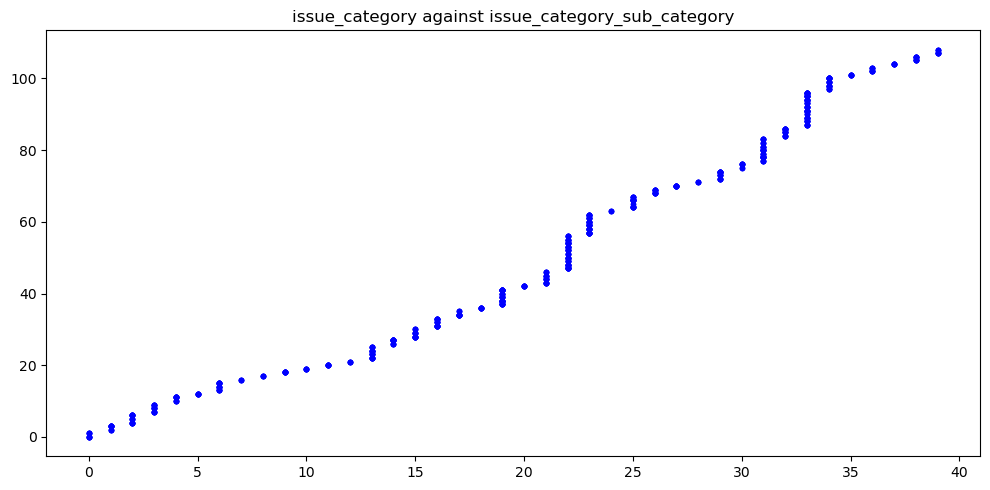

In [20]:
if 1:
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5)) 
    
    
    ax1.plot(df_train["issue_category"], df_train["issue_category_sub_category"], "b.")
    ax1.set_title(f'issue_category against issue_category_sub_category')
    
    plt.tight_layout()
    plt.show()

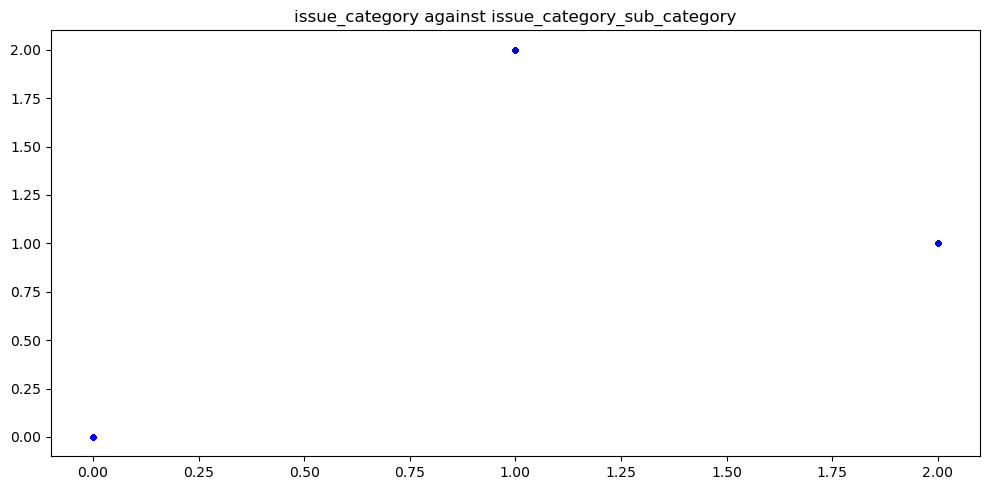

In [21]:
if 1:
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5)) 
    
    
    ax1.plot(df_train["agent_experience_level"], df_train["agent_experience_level_desc"], "b.")
    ax1.set_title(f'issue_category against issue_category_sub_category')
    
    plt.tight_layout()
    plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Drop Unnecessary Features </h2>
</div>

In [22]:
df_train   =   pd.read_csv(path + "train.csv") 
df_test    =   pd.read_csv(path + "test.csv")

In [23]:
df_train   =   df_train[['customer_sentiment', 'conversation']]
df_test    =   df_test[['customer_sentiment', 'conversation']]

In [24]:
df_train.head()

,customer_sentiment,conversation
0,neutral,Agent: Thank you for calling BrownBox Customer...
1,neutral,Agent: Thank you for calling BrownBox customer...
2,neutral,Agent: Thank you for calling BrownBox Customer...
3,neutral,"Customer: Hi, I am facing an issue while loggi..."
4,negative,Agent: Thank you for contacting BrownBox custo...


In [25]:
df_train["conversation"][0]

"Agent: Thank you for calling BrownBox Customer Support. My name is Tom. How may I assist you today?\n\nCustomer: Hi Tom, I'm trying to log in to my account to purchase an Oven Toaster Grill (OTG), but I'm unable to proceed as it's asking for mobile number or email verification. Can you help me with that?\n\nAgent: Sure, I can assist you with that. May I know your registered mobile number or email address, please?\n\nCustomer: My registered mobile number is +1 123-456-7890.\n\nAgent: Thank you. Let me check that for you. I'm sorry to inform you that we don't have this number on our records. Can you please confirm if this is the correct number?\n\nCustomer: Oh, I'm sorry. I might have registered with a different number. Can you please check with my email address instead? It's johndoe@email.com.\n\nAgent: Sure, let me check that for you. (After a few moments) I see that we have your email address on our records. We'll be sending you a verification code shortly. Please check your email an

In [26]:
df_train.dtypes

customer_sentiment    object
conversation          object
dtype: object

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Steps to Preprocess the Data: </h2>
</div>

## 1-) Handle Missing Values: 

We already checked.

## 2-) Text Preprocessing: 

### A-)  Convert POS Tags to WordNet Format :

In [27]:
def get_wordnet_pos(tag):
    """Convert POS tag to WordNet format for better lemmatization"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

### B-)  Preprocess Each Conversation (Tokenization, Lemmatization, Stopword Removal)

In [28]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [29]:
def preprocess_text(text):
    
    """Tokenizes, removes stopwords, and lemmatizes text"""
    
    tokens          = word_tokenize(text.lower())                  # Lowercase & tokenize
    tokens          = [word for word in tokens if word.isalnum()]  # Remove punctuation
    pos_tags        = pos_tag(tokens)                              # POS tagging
    lemmatized      = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    filtered_tokens = [word for word in lemmatized if word not in stop_words]             # Remove stopwords
    
    return " ".join(filtered_tokens)                                                      # Return processed text as a string


In [30]:
df_train["conversation"]   =   df_train["conversation"].apply(preprocess_text)
df_test["conversation"]    =   df_test["conversation"].apply(preprocess_text)

In [31]:
df_train["conversation"][0]

'agent thank call brownbox customer support name tom may assist today customer hi tom try log account purchase oven toaster grill otg unable proceed ask mobile number email verification help agent sure assist may know registered mobile number email address please customer registered mobile number agent thank let check sorry inform number record please confirm correct number customer oh sorry might register different number please check email address instead johndoe agent sure let check moment see email address record send verification code shortly please check email let know receive customer okay receive code agent please enter verification code field provide click email address verify able proceed purchase customer okay enter code verify thank help agent welcome anything else assist customer thank agent welcome great day'

## 3-)  Label Encoding (for Sentiment Classification): 

In [32]:
sentiment_map = {'neutral': 0, 'negative': 1, 'positive': 2} 

In [33]:
df_train['sentiment_label']   =   df_train['customer_sentiment'].map(sentiment_map)
df_test['sentiment_label']    =   df_test['customer_sentiment'].map(sentiment_map)

In [34]:
df_train.head()[:2]

,customer_sentiment,conversation,sentiment_label
0,neutral,agent thank call brownbox customer support nam...,0
1,neutral,agent thank call brownbox customer support nam...,0


In [35]:
len(df_train)

970

In [36]:
if 1:
    print(df_train['conversation'].isnull().sum())
    print(df_train['sentiment_label'].isnull().sum())

0
0


## 4-)  Tokenization : 

In [37]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [38]:
max_length = df_train["conversation"].apply(len).max()
print("Maximum conversation length:", max_length)

Maximum conversation length: 3517


count     970.000000
mean     1253.548454
std       342.593303
min        28.000000
25%      1027.000000
50%      1217.000000
75%      1428.250000
max      3517.000000
Name: conversation, dtype: float64


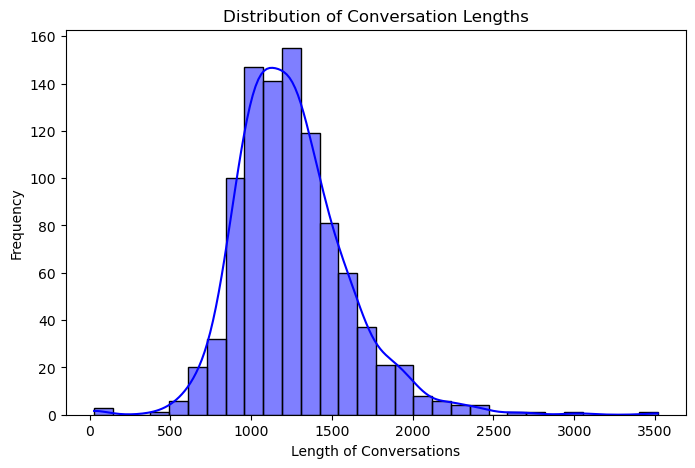

In [39]:
lengths = df_train["conversation"].apply(len)
print(lengths.describe())  
plt.figure(figsize=(8, 5))
sns.histplot(lengths, bins=30, kde=True, color="blue")  
plt.title("Distribution of Conversation Lengths")
plt.xlabel("Length of Conversations")
plt.ylabel("Frequency")
plt.show()

In [40]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

df_train['tokenized_conversation'] = df_train['conversation'].apply(
    lambda x: tokenizer.encode(x, truncation=True, padding='max_length', max_length=1024)
)

df_test['tokenized_conversation'] = df_test['conversation'].apply(
    lambda x: tokenizer.encode(x, truncation=True, padding='max_length', max_length=1024)
)

max_length = 512 

1. Consistent Input Shape: Helps when batching data in deep learning models (like transformers).
2. Memory Optimization: Prevents excessive tokenization, ensuring each input stays within 512 tokens (a common limit in models like GPT-2 and BERT).
3. Prevents Errors: Some transformer architectures require fixed input lengths.

In [41]:
df_train.head() [:2]

,customer_sentiment,conversation,sentiment_label,tokenized_conversation
0,neutral,agent thank call brownbox customer support nam...,0,"[25781, 5875, 869, 7586, 3524, 6491, 1104, 143..."
1,neutral,agent thank call brownbox customer support nam...,0,"[25781, 5875, 869, 7586, 3524, 6491, 1104, 143..."


In [42]:
len(df_train)

970

In [43]:
if 1:
    print(df_train['conversation'].isnull().sum())
    print(df_train['sentiment_label'].isnull().sum())

0
0


In [44]:
len(df_train["tokenized_conversation"])

970

In [45]:
if 1:
    vocab_size = tokenizer.vocab_size
    print("Vocabulary size:", vocab_size)

Vocabulary size: 50257


## 5-)   Prepare Data for Training: 

In [55]:
x_train   =   df_train['tokenized_conversation'].tolist()
y_train   =   df_train['sentiment_label'].values 

x_test    =   df_test['tokenized_conversation'].tolist()
y_test    =   df_test['sentiment_label'].values  

In [56]:
len(x_train), len(y_train)

(970, 970)

In [57]:
len(x_test), len(y_test)

(30, 30)

## 6-)  Convert Data to Tensors : 

In [58]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train) 

x_test  = torch.tensor(x_test)
y_test  = torch.tensor(y_test) 

## 7-)   Prepare the Dataset for Training:  

In [59]:
class SentimentDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {'input_ids': self.x[idx], 'labels': self.y[idx]}

In [60]:
train_set    =   SentimentDataset(x_train, y_train)
test_set     =   SentimentDataset(x_test, y_test)

In [61]:
train_size   =    int(0.9 * len(train_set))
val_size     =    len(train_set) - train_size

In [62]:
train_dataset, val_dataset = random_split(train_set, [train_size, val_size]) 

In [63]:
train_loader   =   DataLoader(train_set, batch_size=4, shuffle=True)
val_loader     =   DataLoader(val_dataset,   batch_size=4, shuffle=False)
test_loader    =   DataLoader(test_set   ,   batch_size=4, shuffle=True)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  NanoGPT </h2>
</div>

NanoGPT From Andrej Karpathy 

link : https://github.com/karpathy/nanoGPT/blob/master/model.py 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Layer Normalization </h2>
</div>

In [64]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias   = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5) 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Causal Self Attention </h2>
</div>

In [65]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        
        # regularization
        self.attn_dropout   =   nn.Dropout(config.dropout)
        self.resid_dropout  =   nn.Dropout(config.dropout)
        self.n_head         =   config.n_head
        self.n_embd         =   config.n_embd
        self.dropout        =   config.dropout
        
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

        
    def forward(self, x):
        
        B, T, C = x.size()            # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y   = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
            
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Configuration class </h2>
</div>

In [58]:
@dataclass
class GPTConfig:
    block_size: int =   1024
    vocab_size: int =   50304    # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int    =   12
    n_head: int     =   12
    n_embd: int     =   768
    dropout: float  =   0.0
    bias: bool      =   True    # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


Why is block_size Important?

    Controls memory usage: Longer sequences require more GPU/CPU memory.
    Defines training efficiency: Larger block sizes allow more context but slow down training.
    Determines attention scope: Transformer self-attention can only process up to block_size tokens.

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Checking the Dimensions </h2>
</div>

In [59]:
if 0:
    config  =  GPTConfig() 

In [60]:
if 0:
    c       =  CausalSelfAttention(config)

In [61]:
if 0:
    dummy   =   torch.zeros(8, 100, 768)

In [62]:
if 0:
    x       =  c.forward(dummy)  

In [63]:
if 0:
    x.shape

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Multi-Layer Perceptron </h2>
</div>

In [66]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Checking the Dimensions </h2>
</div>

In [65]:
if 0:
    mlp    =   MLP(config)

In [66]:
if 0:
    x1  =  mlp.forward(x)

In [67]:
if 0:
    x1.shape

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Transformer Decoder Block </h2>
</div>

In [67]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp  = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Nano-GPT : Decoder-Only Transformer </h2>
</div>

In [68]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte    = nn.Embedding(config.vocab_size, config.n_embd),
            wpe    = nn.Embedding(config.block_size, config.n_embd),
            drop   = nn.Dropout(config.dropout),
            h      = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f   = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))
#----------------------------------------------------------------------------------------------------------------------------
    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params
#----------------------------------------------------------------------------------------------------------------------------
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
#----------------------------------------------------------------------------------------------------------------------------
    def forward(self, idx, targets=None):
        
        device    = idx.device
        b, t      = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos       = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
#----------------------------------------------------------------------------------------------------------------------------
    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]
#----------------------------------------------------------------------------------------------------------------------------
    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
#----------------------------------------------------------------------------------------------------------------------------
    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer
#----------------------------------------------------------------------------------------------------------------------------
    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu
#----------------------------------------------------------------------------------------------------------------------------
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Employ GPU</h2>
</div>

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
device

device(type='cuda')

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Dimension Check</h2>
</div>

In [72]:
if 0:
    
    b, t, n_embd   =   2, 512, 768                        # Batch size, sequence length, embedding dim
    idx            =   torch.randint(0, 50304, (b, t))    # Random token indices from vocab size 50257 (GPT-2) 

In [73]:
if 0:
    idx.shape

In [74]:
if 0:
    modelx   =   GPT(config)

In [75]:
if 0:
    x   =   modelx.forward(idx)

In [76]:
if 0:
    x[0].shape

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Classification Head for Sentiment Classification</h2>
</div>

In [71]:
if 1:

    class GPTForClassification(GPT):
        
        def __init__(self, config, num_classes, class_weights=None):
            super().__init__(config)
            
            self.classifier    = nn.Linear(config.vocab_size, num_classes)
     
            self.class_weights = class_weights
    
        def forward(self, idx, targets=None):
            
            logits, _  =   super().forward(idx)
            rep        =   logits[:, -1, :]
            logits     =   self.classifier(rep)
            loss       =   None
            
            if targets is not None:
                if self.class_weights is not None:
                    loss = F.cross_entropy(logits, targets, weight=self.class_weights)
                else:
                    loss = F.cross_entropy(logits, targets)
            return logits, loss

In [78]:
if 0:
    modelx2   =   GPTForClassification(config, 3)

In [79]:
if 0:
    y2   =   torch.tensor(
    [[0., 0., 2.],
        [0., 1., 2.]]
    )

In [80]:
if 0:
    y2

In [81]:
if 0:
    x2   =   modelx2.forward(idx, y2)

In [82]:
if 0:
    x2[0].shape

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Configuration for parameters (Nano-GPT) </h2>
</div>

In [72]:
@dataclass
class GPTConfig:
    block_size: int =   1024
    vocab_size: int =   50304    # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int    =   8
    n_head: int     =   12
    n_embd: int     =   768
    dropout: float  =   0.2
    bias: bool      =   True    # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


In [73]:
config   =  GPTConfig()  

In [85]:
run.config.update(config)

In [74]:
weights = torch.tensor([1.0, 1.0, 10.0])  
weights = weights.to(device) 

In [75]:
model = GPTForClassification(config, num_classes=3).to(device)

number of parameters: 95.34M


<div span style="background-color:green;    color:red;      text-align:center;    padding:5px;">
<h2>  Fine-Tuning for GPT-2</h2>
</div>

In [89]:
@dataclass
class GPTConfig:
    block_size: int =   1024
    vocab_size: int =   50257    # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int    =   12
    n_head: int     =   12
    n_embd: int     =   768
    dropout: float  =   0.2
    bias: bool      =   True    # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


In [90]:
pre_trained = GPT.from_pretrained("gpt2")   

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
number of parameters: 123.65M


In [91]:
config   =  pre_trained.config

In [92]:
if 0:

    dummy_input = torch.randint(0, config.vocab_size, (2, 10))

    # For inference (targets=None):
    logits, loss = pre_trained(dummy_input)
    print("Inference output shape:", logits.shape)

Actually, we only changed the input dimension to the linear layer for classification . 

In [93]:
if 1:
    class GPTForClassification_pretrained(GPT):

        def __init__(self, config, num_classes, class_weights=None):
            super().__init__(config)
            
            self.classifier    = nn.Linear(config.vocab_size, num_classes)
     
            self.class_weights = class_weights
    
        def forward(self, idx, targets=None):
            
            logits, _  =   super().forward(idx)
            rep        =   logits[:, -1, :]
            logits     =   self.classifier(rep)
            loss       =   None
            
            if targets is not None:
                if self.class_weights is not None:
                    loss = F.cross_entropy(logits, targets, weight=self.class_weights)
                else:
                    loss = F.cross_entropy(logits, targets)
            return logits, loss


In [94]:
weights = torch.tensor([1.0, 1.0, 10.0])  
weights = weights.to(device)

In [95]:
model = GPTForClassification_pretrained(config, num_classes=3, class_weights=None)
model = model.to(device)

number of parameters: 123.65M


In [ ]:
if 0:

    l1, l2   =  modelx3.forward(dummy_input)

In [ ]:
#l1.shape

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Transfer Learning : Freeze some layers :  </h2>
</div>

In [ ]:
for param in modelx3.parameters():
    param.requires_grad = False

for param in modelx3.classifier.parameters():
    param.requires_grad = True

# Unfreeze only the last 2 layers of the transformer blocks
# Assuming model_cls.transformer.h is a ModuleList containing the transformer layers
for layer in modelx3.transformer.h[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Optionally, unfreeze the final layer norm if needed
for param in modelx3.transformer.ln_f.parameters():
    param.requires_grad = True

In [ ]:
total_params = sum(p.numel() for p in modelx3.parameters())
print(f"Total parameters: {total_params}")

In [ ]:
trainable_params = sum(p.numel() for p in modelx3.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

In [ ]:
#   14 328 054 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  To Save Weights and Losses : </h2>
</div>

In [96]:
#path_model   =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_1/weights/Transformers_weights_1.pth"
#path_losses  =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_1/weights/Transformers_losses_1.pth"


path_model   =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_1/weights/Transformers_pre_trained_weights_1.pth"
path_losses  =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_1/weights/Transformers_pre_trained_losses_1.pth"

In [82]:
if 0:
    
    torch.save({
            'model_state_dict': model.state_dict(),
            'best_loss'       : 9999999999999,
        }, path_model)   

In [83]:
if 0:
    
    torch.save({
        
            'train_loss'    : [],
            'val_loss'      : [], 
    
            'epochs'        : [],
    
        }, path_losses)    

In [97]:
if 1:
    
    checkpoint_weights   =   torch.load(path_model, weights_only=True) 
    checkpoint_losses    =   torch.load(path_losses, weights_only=True)  
    
    model.load_state_dict(checkpoint_weights['model_state_dict'])
    
    best_loss       =  checkpoint_weights['best_loss'] 
    train_loss      =  checkpoint_losses['train_loss']
    val_loss        =  checkpoint_losses['val_loss']
    
    epochs          =  checkpoint_losses['epochs'] 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check for dimensions </h2>
</div>

In [ ]:
for batch in dataloader_train:
        
    break

In [ ]:
batch["input_ids"].shape

In [ ]:
x  =  modelx.forward(batch["input_ids"])
x[0].shape

In [ ]:
#x1  =  x[0].squeeze(1)
#x1.shape

In [ ]:
rep  =   x[0][:, -1, :] 

In [ ]:
rep.shape

In [ ]:
x   =  model(batch["input_ids"].to(device))

In [ ]:
x[0].shape

#   Second Phase : Fine-Tune Pre-trained GPT-2:

###  After training model for classification layer and last layer of GPT-2 
###  Now, we should change all weights slowly

In [ ]:

for param in model.parameters():
    
    param.requires_grad = True

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Training : </h2>
</div>

In [93]:
def train(num_epochs=10, counter=0, patience=10, best_loss=best_loss):
    

    lr        = 0.0001
    optimizer = AdamW(model.parameters(), lr=lr)
    
    run.log({"LR": lr})  
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
    scaler    = GradScaler()

    for epoch in range(num_epochs):
    
        model.train()
        total_loss_train = 0
        
        for batch in tqdm.tqdm(train_loader):
            
            inputs   =   batch["input_ids"]
            labels   =   batch["labels"]
            
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                
                logits, loss = model(inputs, labels)
                
            scaler.scale(loss).backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
            scaler.step(optimizer)
            scaler.update()
    
            total_loss_train += loss.item()

        total_loss_train     /= len(train_loader)

        train_loss.append(total_loss_train)
    

        # Log metrics to wandb.
        run.log({"Train Loss": total_loss_train})
    

        if torch.isnan(torch.tensor(total_loss_train)):
            print("NaN value encountered!")
            break

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train Loss : {total_loss_train:.4f}           |")
        print("-------------------------------------------------------------------------------")

#-----------------------------------------------------------------------------------------------

        
        model.eval()

        total_loss_val      =   0.0

        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

                inputs   =   batch["input_ids"]
                labels   =   batch["labels"]
            
                inputs, labels = inputs.to(device), labels.to(device)
        

                logits, loss = model(inputs, labels)

                total_loss_val     += loss.item()

        total_loss_val     /= len(val_loader)

        val_loss.append(total_loss_val)

        run.log({"Val Loss": total_loss_val})

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation Loss : {total_loss_val:.4f}           |")
        print("-------------------------------------------------------------------------------")

        
        if len(val_loss) >= 2:
            res = ((val_loss[-2] - val_loss[-1]) / val_loss[-2]) * 100
            print("-------------------------------------------------------------------------------")
            print(f"|              Change in loss is      %   {res:.2f}                               |")
            print("-------------------------------------------------------------------------------")

        if  total_loss_val < best_loss:
            
            print("*************...saving best model *************")
            
            best_loss = total_loss_val
            
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_loss'       : best_loss,
            }, path_model)
             

        epochs.append(epoch)

        torch.save({
        
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epochs': epochs,
        }, path_losses)

        if (len(val_loss) >= 2) and (val_loss[-2] > val_loss[-1]):
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break

        scheduler.step()  
        torch.cuda.empty_cache()

In [94]:
train(num_epochs=50, best_loss=best_loss)

100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [1/50]          |        Total Train Loss : 1.4934           |
-------------------------------------------------------------------------------


Epoch 1/50: 100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


-------------------------------------------------------------------------------
|  Epoch [1/50]         |       Total Validation Loss : 0.9953           |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [2/50]          |        Total Train Loss : 0.7002           |
-------------------------------------------------------------------------------


Epoch 2/50: 100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


-------------------------------------------------------------------------------
|  Epoch [2/50]         |       Total Validation Loss : 0.5764           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   42.08                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [3/50]          |        Total Train Loss : 0.4402           |
-------------------------------------------------------------------------------


Epoch 3/50: 100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


-------------------------------------------------------------------------------
|  Epoch [3/50]         |       Total Validation Loss : 0.6653           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -15.41                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [4/50]          |        Total Train Loss : 0.4532           |
-------------------------------------------------------------------------------


Epoch 4/50: 100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


-------------------------------------------------------------------------------
|  Epoch [4/50]         |       Total Validation Loss : 0.4264           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   35.91                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [5/50]          |        Total Train Loss : 0.3208           |
-------------------------------------------------------------------------------


Epoch 5/50: 100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


-------------------------------------------------------------------------------
|  Epoch [5/50]         |       Total Validation Loss : 0.3267           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   23.38                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [6/50]          |        Total Train Loss : 0.2934           |
-------------------------------------------------------------------------------


Epoch 6/50: 100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


-------------------------------------------------------------------------------
|  Epoch [6/50]         |       Total Validation Loss : 0.3814           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -16.75                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [7/50]          |        Total Train Loss : 0.2741           |
-------------------------------------------------------------------------------


Epoch 7/50: 100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


-------------------------------------------------------------------------------
|  Epoch [7/50]         |       Total Validation Loss : 0.3899           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -2.22                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [8/50]          |        Total Train Loss : 0.4502           |
-------------------------------------------------------------------------------


Epoch 8/50: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


-------------------------------------------------------------------------------
|  Epoch [8/50]         |       Total Validation Loss : 0.6522           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -67.27                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.74it/s]


-------------------------------------------------------------------------------
|  Epoch [9/50]          |        Total Train Loss : 0.2825           |
-------------------------------------------------------------------------------


Epoch 9/50: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


-------------------------------------------------------------------------------
|  Epoch [9/50]         |       Total Validation Loss : 0.5365           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   17.73                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [10/50]          |        Total Train Loss : 0.2797           |
-------------------------------------------------------------------------------


Epoch 10/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [10/50]         |       Total Validation Loss : 0.2402           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   55.22                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [11/50]          |        Total Train Loss : 0.1875           |
-------------------------------------------------------------------------------


Epoch 11/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [11/50]         |       Total Validation Loss : 0.2274           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   5.33                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [12/50]          |        Total Train Loss : 0.1785           |
-------------------------------------------------------------------------------


Epoch 12/50: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


-------------------------------------------------------------------------------
|  Epoch [12/50]         |       Total Validation Loss : 0.1994           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   12.33                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [13/50]          |        Total Train Loss : 0.1608           |
-------------------------------------------------------------------------------


Epoch 13/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [13/50]         |       Total Validation Loss : 0.2654           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -33.12                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [14/50]          |        Total Train Loss : 0.1450           |
-------------------------------------------------------------------------------


Epoch 14/50: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


-------------------------------------------------------------------------------
|  Epoch [14/50]         |       Total Validation Loss : 0.2224           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   16.20                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [15/50]          |        Total Train Loss : 0.1398           |
-------------------------------------------------------------------------------


Epoch 15/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [15/50]         |       Total Validation Loss : 0.2105           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   5.36                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [16/50]          |        Total Train Loss : 0.1701           |
-------------------------------------------------------------------------------


Epoch 16/50: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


-------------------------------------------------------------------------------
|  Epoch [16/50]         |       Total Validation Loss : 0.1581           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   24.89                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [17/50]          |        Total Train Loss : 0.1532           |
-------------------------------------------------------------------------------


Epoch 17/50: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


-------------------------------------------------------------------------------
|  Epoch [17/50]         |       Total Validation Loss : 0.1712           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -8.30                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [18/50]          |        Total Train Loss : 0.1414           |
-------------------------------------------------------------------------------


Epoch 18/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [18/50]         |       Total Validation Loss : 0.2358           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -37.70                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [19/50]          |        Total Train Loss : 0.1800           |
-------------------------------------------------------------------------------


Epoch 19/50: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


-------------------------------------------------------------------------------
|  Epoch [19/50]         |       Total Validation Loss : 0.2770           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -17.48                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [20/50]          |        Total Train Loss : 0.1927           |
-------------------------------------------------------------------------------


Epoch 20/50: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


-------------------------------------------------------------------------------
|  Epoch [20/50]         |       Total Validation Loss : 0.3429           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -23.79                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [21/50]          |        Total Train Loss : 0.1322           |
-------------------------------------------------------------------------------


Epoch 21/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [21/50]         |       Total Validation Loss : 0.1665           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   51.45                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.72it/s]


-------------------------------------------------------------------------------
|  Epoch [22/50]          |        Total Train Loss : 0.1149           |
-------------------------------------------------------------------------------


Epoch 22/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [22/50]         |       Total Validation Loss : 0.1581           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   5.00                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [23/50]          |        Total Train Loss : 0.1153           |
-------------------------------------------------------------------------------


Epoch 23/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [23/50]         |       Total Validation Loss : 0.1433           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   9.41                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [24/50]          |        Total Train Loss : 0.1075           |
-------------------------------------------------------------------------------


Epoch 24/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [24/50]         |       Total Validation Loss : 0.1369           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   4.42                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [25/50]          |        Total Train Loss : 0.1126           |
-------------------------------------------------------------------------------


Epoch 25/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [25/50]         |       Total Validation Loss : 0.1585           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -15.78                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [26/50]          |        Total Train Loss : 0.1109           |
-------------------------------------------------------------------------------


Epoch 26/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [26/50]         |       Total Validation Loss : 0.1638           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -3.30                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [27/50]          |        Total Train Loss : 0.0999           |
-------------------------------------------------------------------------------


Epoch 27/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [27/50]         |       Total Validation Loss : 0.1620           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   1.06                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [28/50]          |        Total Train Loss : 0.0996           |
-------------------------------------------------------------------------------


Epoch 28/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [28/50]         |       Total Validation Loss : 0.1460           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   9.90                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [29/50]          |        Total Train Loss : 0.1638           |
-------------------------------------------------------------------------------


Epoch 29/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [29/50]         |       Total Validation Loss : 0.1228           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   15.87                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [30/50]          |        Total Train Loss : 0.2091           |
-------------------------------------------------------------------------------


Epoch 30/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [30/50]         |       Total Validation Loss : 0.1833           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -49.26                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [31/50]          |        Total Train Loss : 0.1636           |
-------------------------------------------------------------------------------


Epoch 31/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [31/50]         |       Total Validation Loss : 0.2137           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -16.58                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [32/50]          |        Total Train Loss : 0.1282           |
-------------------------------------------------------------------------------


Epoch 32/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [32/50]         |       Total Validation Loss : 0.3413           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -59.66                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.74it/s]


-------------------------------------------------------------------------------
|  Epoch [33/50]          |        Total Train Loss : 0.1419           |
-------------------------------------------------------------------------------


Epoch 33/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [33/50]         |       Total Validation Loss : 0.1393           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   59.19                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [34/50]          |        Total Train Loss : 0.1373           |
-------------------------------------------------------------------------------


Epoch 34/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [34/50]         |       Total Validation Loss : 0.1242           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   10.79                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [35/50]          |        Total Train Loss : 0.1276           |
-------------------------------------------------------------------------------


Epoch 35/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [35/50]         |       Total Validation Loss : 0.1715           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -38.08                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [36/50]          |        Total Train Loss : 0.1282           |
-------------------------------------------------------------------------------


Epoch 36/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [36/50]         |       Total Validation Loss : 0.0944           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   44.97                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [37/50]          |        Total Train Loss : 0.0972           |
-------------------------------------------------------------------------------


Epoch 37/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [37/50]         |       Total Validation Loss : 0.0982           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -4.03                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [38/50]          |        Total Train Loss : 0.0983           |
-------------------------------------------------------------------------------


Epoch 38/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [38/50]         |       Total Validation Loss : 0.0902           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   8.13                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [39/50]          |        Total Train Loss : 0.0898           |
-------------------------------------------------------------------------------


Epoch 39/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [39/50]         |       Total Validation Loss : 0.0957           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -6.06                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [40/50]          |        Total Train Loss : 0.1035           |
-------------------------------------------------------------------------------


Epoch 40/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [40/50]         |       Total Validation Loss : 0.0948           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   0.89                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [41/50]          |        Total Train Loss : 0.1019           |
-------------------------------------------------------------------------------


Epoch 41/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [41/50]         |       Total Validation Loss : 0.0967           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -1.92                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [42/50]          |        Total Train Loss : 0.0885           |
-------------------------------------------------------------------------------


Epoch 42/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [42/50]         |       Total Validation Loss : 0.1184           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -22.44                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [43/50]          |        Total Train Loss : 0.0973           |
-------------------------------------------------------------------------------


Epoch 43/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [43/50]         |       Total Validation Loss : 0.1371           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -15.86                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [44/50]          |        Total Train Loss : 0.1210           |
-------------------------------------------------------------------------------


Epoch 44/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [44/50]         |       Total Validation Loss : 0.1130           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   17.60                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [45/50]          |        Total Train Loss : 0.1837           |
-------------------------------------------------------------------------------


Epoch 45/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [45/50]         |       Total Validation Loss : 0.1193           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -5.59                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [46/50]          |        Total Train Loss : 0.2154           |
-------------------------------------------------------------------------------


Epoch 46/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [46/50]         |       Total Validation Loss : 0.1395           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -16.93                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [47/50]          |        Total Train Loss : 0.1294           |
-------------------------------------------------------------------------------


Epoch 47/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [47/50]         |       Total Validation Loss : 0.1160           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   16.85                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [48/50]          |        Total Train Loss : 0.1113           |
-------------------------------------------------------------------------------


Epoch 48/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


-------------------------------------------------------------------------------
|  Epoch [48/50]         |       Total Validation Loss : 0.1418           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -22.24                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [49/50]          |        Total Train Loss : 0.1097           |
-------------------------------------------------------------------------------


Epoch 49/50: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


-------------------------------------------------------------------------------
|  Epoch [49/50]         |       Total Validation Loss : 0.1542           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -8.72                               |
-------------------------------------------------------------------------------


100%|██████████| 243/243 [00:51<00:00,  4.73it/s]


-------------------------------------------------------------------------------
|  Epoch [50/50]          |        Total Train Loss : 0.1100           |
-------------------------------------------------------------------------------


Epoch 50/50: 100%|██████████| 25/25 [00:04<00:00,  6.21it/s]

-------------------------------------------------------------------------------
|  Epoch [50/50]         |       Total Validation Loss : 0.2376           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   -54.11                               |
-------------------------------------------------------------------------------


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Accuracy Score on Unseen data : </h2>
</div>

In [98]:
model  =  model.to(device)

model.eval()

all_preds, all_labels = [], []

for batch in tqdm.tqdm(test_loader):
        
    inputs   =   batch["input_ids"]
    labels   =   batch["labels"]
    
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        logits, _ = model(inputs)
        preds     = torch.argmax(logits, dim=1).cpu().numpy()

    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())


acc  =  accuracy_score(all_labels, all_preds)


print(f"Accuracy: {acc:.4f}")

#run.log({"acc": acc})

100%|██████████| 8/8 [00:01<00:00,  4.08it/s]

Accuracy: 0.7000


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Confusion Matrix</h2>
</div>

In [99]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10  0  0]
 [ 1  9  0]
 [ 8  0  2]]


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Heatmap</h2>
</div>

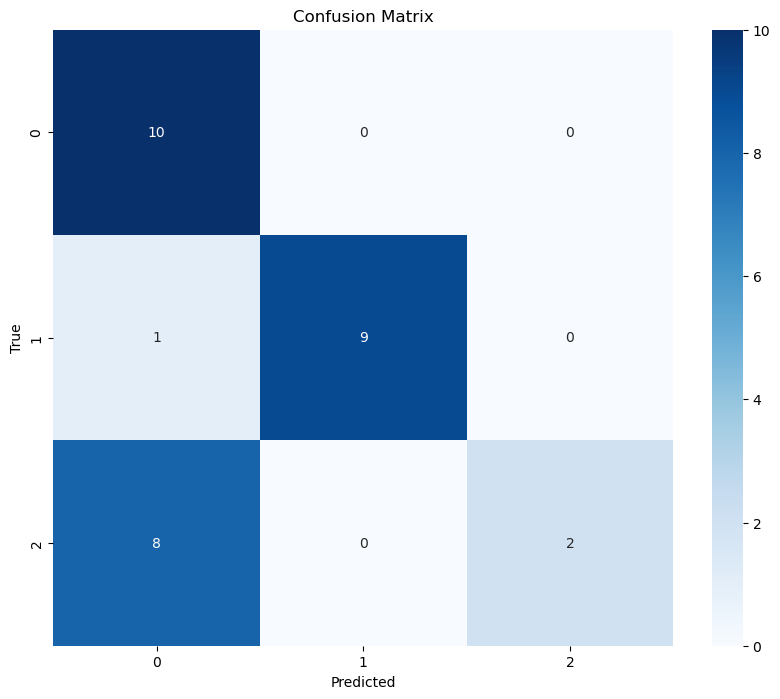

In [100]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Sync for WANDB</h2>
</div>

In [98]:
run.finish() 

LR,▁
Train Loss,█▄▃▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
Val Loss,█▅▅▄▃▃▅▄▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂
LR,0.0001
Train Loss,0.10997
Val Loss,0.2376
